In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import time
import datetime

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

## set working dir

In [7]:
import os
os.chdir("../data")
print (os.getcwd())

C:\Users\Sean\Desktop\Reddit-Analysis\data


In [8]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [9]:
def load_data(path):
    reddit_ids = []
    data = []
    with open(path, 'r', newline='\n') as f:
        for line in f:
            reddit_id, comments = line.split('\t', maxsplit=1)

            data.append(comments)
            reddit_ids.append(reddit_id)
    return reddit_ids, data

In [13]:
def load_hash(path):
    d = {}
    with open(path, 'r', newline='\n') as f:
        for line in f:
            reddit_id, field = line.split('\t', maxsplit=1)
            d[reddit_id] = field
    return d

In [14]:
path1 = './worldnews_2017_1-2017_1_flatcomments.txt'
path2 = './worldnews_2017_1-2017_1_submissiondates.txt'

## read comments and dates

In [15]:
reddit_ids, comments = load_data(path1)
dates = load_hash(path2)


In [16]:
print (len(comments), len(dates))

609 831


## join on reddit id

In [113]:
data_samples = []
samples_dates = []
for r, c in zip(reddit_ids, comments):
    if r in dates:
        samples_dates.append(dates[r].strip())
        data_samples.append(c)
print (len(data_samples), len(samples_dates))

609 609


In [20]:
n_features = 1000
n_components = 10
n_top_words = 20
n_samples = 604

In [21]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time.time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time.time() - t0))

Extracting tf-idf features for NMF...
done in 4.315s.


In [22]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time.time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time.time() - t0))
print()

Extracting tf features for LDA...
done in 4.418s.



In [23]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time.time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time.time() - t0))

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=604 and n_features=1000...
done in 1.276s.


In [24]:
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model (Frobenius norm):
Topic #0: trump obama president election hillary clinton vote intelligence donald putin america party politics american voted executive political democrats republicans republican
Topic #1: russia russian ukraine putin nato russians crimea war troops military syria sanctions poland nuclear soviet propaganda eu europe assad nukes
Topic #2: israel palestinians palestinian israeli palestine jews jerusalem jewish hamas arabs arab israelis land gaza peace bank state war west terrorist
Topic #3: china chinese war taiwan trade korea india japan nuclear military sea coal south north countries power pakistan nukes economy japanese
Topic #4: mexico wall mexican border trade trump nafta immigration immigrants illegal american america economy jobs goods pay manufacturing drugs canada americans
Topic #5: money tax income pay taxes work company wage jobs rich companies wealth government job welfare paid economy minimum workers market
Topic #6: eu uk brexit trade

In [25]:
tfidf.shape

(609, 1000)

In [26]:
H = nmf.components_; H.shape

(10, 1000)

In [27]:
W = nmf.fit_transform(tfidf); W.shape

(609, 10)

## load into pandas DataFrame and plot

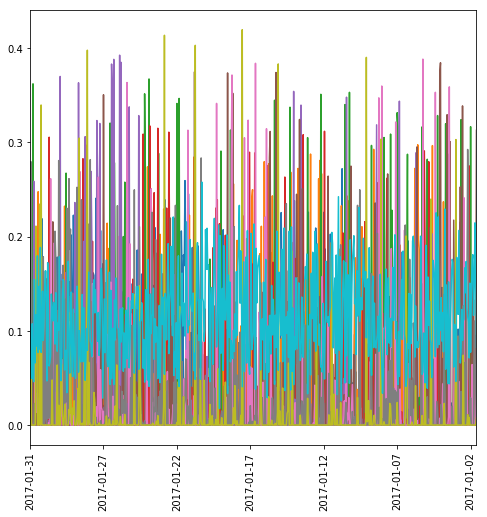

In [114]:
df1 = pd.DataFrame(W,index=samples_dates)
df1.plot(figsize=(8.0,8.0),rot=90,legend=False)

## NMF model
NMF model is based on finding $W$ and $H$ that minimises:

$$ ||X - WH||_{F} $$

In this case:

$X_{604 \times 1000} $ is the matrix of samples (comments from a submission) by features (words)

$W_{604 \times10}$ is the matrix of samples to topics, and 

$H_{10 \times 1000}$ is matrix of topics to features  

Also a bunch of other stuff I don't understand yet...

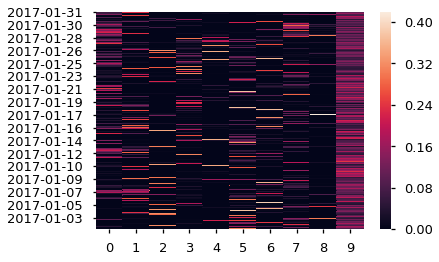

In [115]:
with sns.plotting_context('talk'):
    sns.heatmap(df1)

In [30]:
nmf.reconstruction_err_ # I dont' know if this is a good error or not...

18.23455471308522